# **Customer Segmentation: Enhancing Clustering with Neural Networks**

## **1. Project Objective: Model Tuning & Architecture Search**
The goal of this project is to improve the performance of our customer segmentation model by integrating **Neural Network (NN) architecture**.

In our previous iteration, we established a baseline using standard **K-Means Clustering**. In this iteration, we aim to enhance feature representation using an **Autoencoder (Neural Network)** before applying the clustering algorithm, effectively tuning the model to capture non-linear patterns in the RFM data.

## **2. Theoretical Background**
### The Baseline: What is K-Means Clustering?
To understand our target, we must first define the baseline method. K-means clustering is a simple way to automatically group similar things together. You tell the algorithm how many groups—called clusters—you want, and it tries to organize your data so that items in the same group are close to each other, while groups themselves are far apart.

### The Tuning Strategy: Why Neural Networks?
While K-Means is fast, it relies on linear distances (Euclidean). Real-world retail data often contains complex, non-linear relationships. By using a **Neural Network Autoencoder**, we can compress the input data into a dense "latent representation" that removes noise and highlights the most important features, potentially leading to a higher Silhouette Score and better-defined segments.

## **3. Dataset & Feature Context**
Consistent with our baseline study, this project utilizes the same real-world transaction data from a UK-based online retailer (2009–2010). We continue to focus on **RFM Analysis**, utilizing three key features engineered from the raw data:
* **Recency (R):** The number of days since the client's last purchase.
* **Frequency (F):** The total number of purchases/unique invoices made by the client.
* **Monetary Value (M):** The sum total monetary contribution (in GBP) of each client.

In [1]:
# --- Standard Data Science Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clustering & Machine Learning ---
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch # For the Dendrogram

# --- Preprocessing ---
from sklearn.preprocessing import StandardScaler

# --- Deep Learning ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- Display Settings ---
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option("display.max_columns", 999)

# Suppress warnings for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

## **4. Data Loading & Initial Inspection**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Importing dataset

file_path = '/content/drive/My Drive/Online Retail.xlsx'

df = pd.read_excel(file_path)

df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.00,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.00,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.00,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## **5. Data Cleaning & Filtering**
In our previous project, during exploratory analysis we identified several data quality issues: missing customer IDs, negative quantities (returns), and non-product transactions (postage, fees). We apply the following cleaning rules:

1.  **Drop Missing IDs:** Records without a `CustomerID` are removed as they cannot be used for user-level segmentation.
2.  **Remove Cancellations:** We only retain invoices consisting of 6 digits (filtering out 'C' for cancellations and 'A' for adjustments).
3.  **Validate Stock Codes:** We retain standard 5-digit codes, codes with suffixes (e.g., '85123A'), and 'PADS'.
4.  **Price & Quantity Sanity Check:** We remove records with 0 or negative prices.

In [4]:
# 1. Create a copy to avoid SettingWithCopy warnings
cleaned_df = df.copy()

# 2. Drop Missing Customer IDs immediately (Largest reduction)
cleaned_df.dropna(subset=["CustomerID"], inplace=True)

# 3. Filter Invoices: Keep only 6-digit numeric invoices (Removes 'C', 'A')
cleaned_df = cleaned_df[cleaned_df["InvoiceNo"].astype(str).str.match(r"^\d{6}$")]

# 4. Filter Stock Codes: Keep 5-digit, 5-digit+Letter, or 'PADS'
stock_mask = (
    cleaned_df["StockCode"].astype(str).str.match(r"^\d{5}$") |
    cleaned_df["StockCode"].astype(str).str.match(r"^\d{5}[a-zA-Z]+$") |
    cleaned_df["StockCode"].astype(str).str.match(r"^PADS$")
)
cleaned_df = cleaned_df[stock_mask]

# 5. Filter Unit Price (Must be > 0)
cleaned_df = cleaned_df[cleaned_df["UnitPrice"] > 0]

# --- Data Loss Summary ---
records_lost = len(df) - len(cleaned_df)
percent_lost = (records_lost / len(df)) * 100

print(f"Original Records: {len(df):,}")
print(f"Cleaned Records:  {len(cleaned_df):,}")
print(f"Data Loss:        {percent_lost:.2f}% ({records_lost:,} rows removed)")

Original Records: 541,909
Cleaned Records:  396,340
Data Loss:        26.86% (145,569 rows removed)


In [5]:
cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France


## **6. Feature Engineering: RFM Analysis**
We transform the transaction-level data into a customer-level dataset using the RFM framework:
* **Recency:** Days since `max(InvoiceDate)` - Customer's `LastInvoiceDate`.
* **Frequency:** Count of unique invoices.
* **Monetary:** Sum of (Quantity * UnitPrice).

In [6]:
# 1. Calculate Total Price per transaction
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["UnitPrice"]

# 2. Aggregate to Customer Level
aggregated_df = cleaned_df.groupby(by="CustomerID", as_index=False).agg(
    MonetaryValue=("SalesLineTotal", "sum"),
    Frequency=("InvoiceNo", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max")
)

# 3. Calculate Recency
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

# Set CustomerID as Index for easier filtering later
aggregated_df.set_index("CustomerID", inplace=True)

aggregated_df.head()

,MonetaryValue,Frequency,LastInvoiceDate,Recency
CustomerID,,,,
12346.00,77183.60,1,2011-01-18 10:01:00,325
12347.00,4310.00,7,2011-12-07 15:52:00,1
12348.00,1437.24,4,2011-09-25 13:13:00,74
12349.00,1457.55,1,2011-11-21 09:51:00,18
12350.00,294.40,1,2011-02-02 16:01:00,309


## **7. Exploratory Data Analysis (EDA)**
Before modeling, we visualize the distribution of Recency, Frequency, and Monetary Value to identify skewness and outliers.

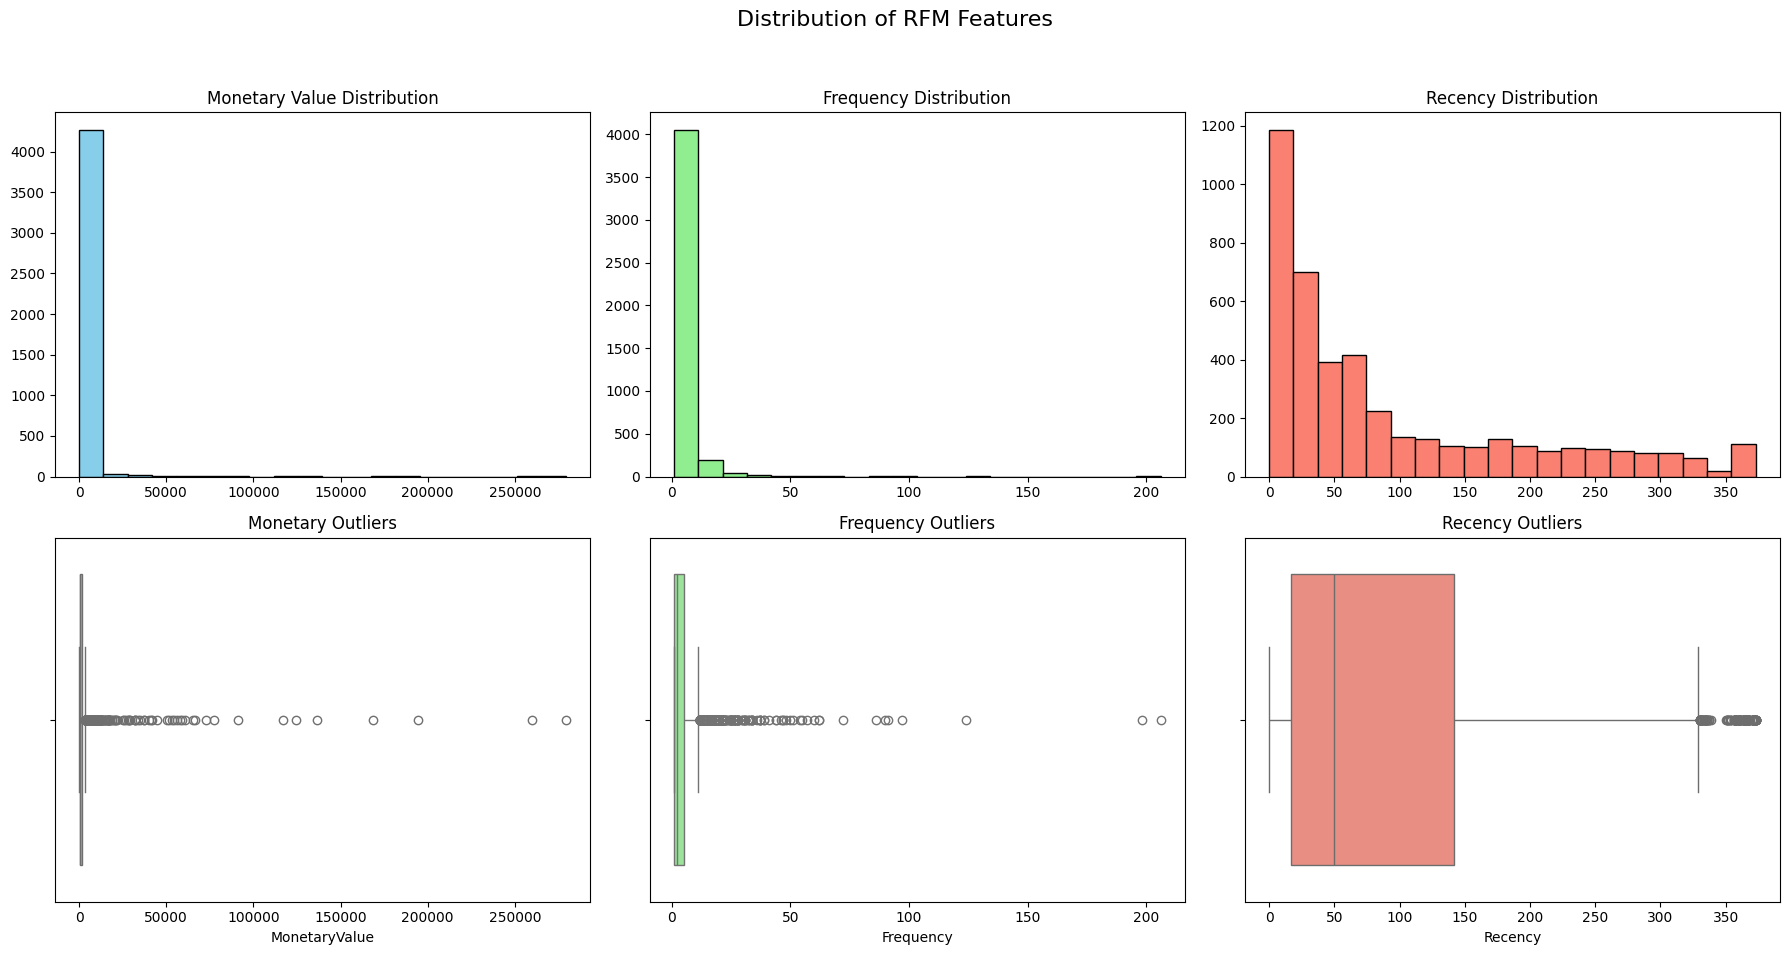

In [9]:
# Create a 2-row visualization layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of RFM Features', fontsize=16)

# Row 1: Histograms
axes[0, 0].hist(aggregated_df['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Monetary Value Distribution')
axes[0, 1].hist(aggregated_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 2].hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
axes[0, 2].set_title('Recency Distribution')

# Row 2: Boxplots (to spot outliers)
sns.boxplot(ax=axes[1, 0], x=aggregated_df['MonetaryValue'], color='skyblue')
axes[1, 0].set_title('Monetary Outliers')
sns.boxplot(ax=axes[1, 1], x=aggregated_df['Frequency'], color='lightgreen')
axes[1, 1].set_title('Frequency Outliers')
sns.boxplot(ax=axes[1, 2], x=aggregated_df['Recency'], color='salmon')
axes[1, 2].set_title('Recency Outliers')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **8. Outlier Handling Strategy**
Extreme outliers in Monetary Value and Frequency were separated from the main dataset. This is necessary because outliers are often the most valuable customers ("Whales"); dropping them harms the business context, but including them skews the clustering algorithms.

We segregate them using the IQR (Interquartile Range) method.

In [10]:
# --- 1. Identify Monetary Outliers ---
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers = aggregated_df[
    (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR)) |
    (aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR))
]

# --- 2. Identify Frequency Outliers ---
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR))]

# --- 3. Separate the Data ---
# We use .index.union() to handle overlaps (customers who are outliers in BOTH)
outlier_indices = monetary_outliers.index.union(frequency_outliers.index)

# Create the clean dataframe by excluding these indices
non_outliers_df = aggregated_df[~aggregated_df.index.isin(outlier_indices)]

print(f"Total Customers: {len(aggregated_df)}")
print(f"Outliers Removed: {len(outlier_indices)}")
print(f"Data for Modeling: {len(non_outliers_df)}")

Total Customers: 4334
Outliers Removed: 471
Data for Modeling: 3863


## **9. Visualizing the Cleaned Data**
After removing outliers, the data distribution is less skewed, making it suitable for standard scaling and Neural Network processing.

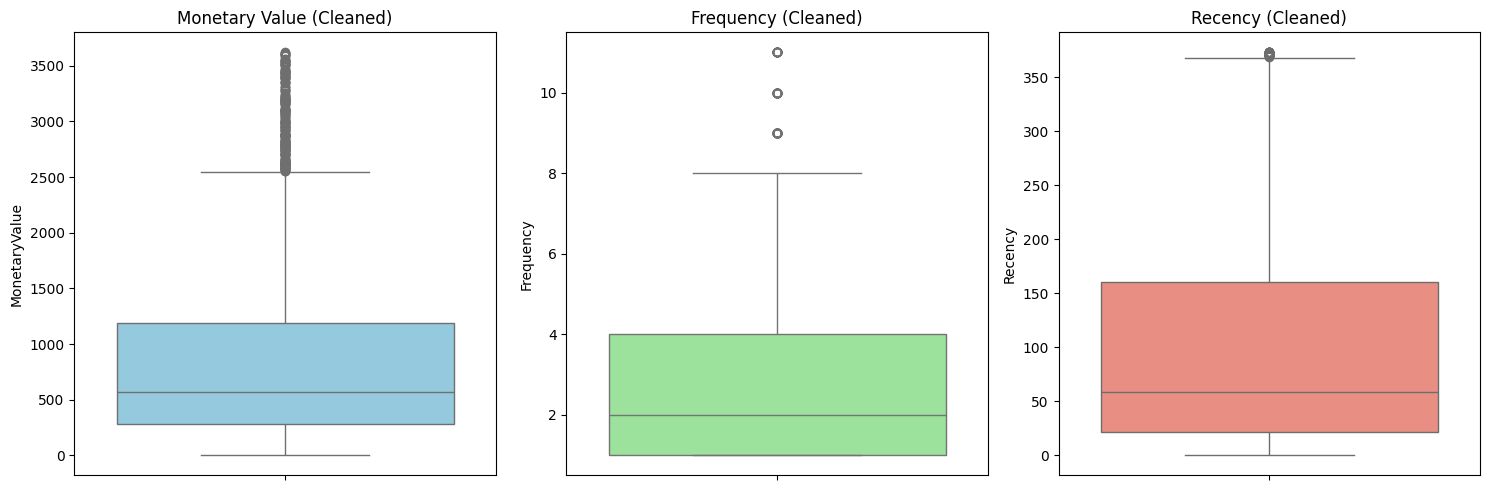

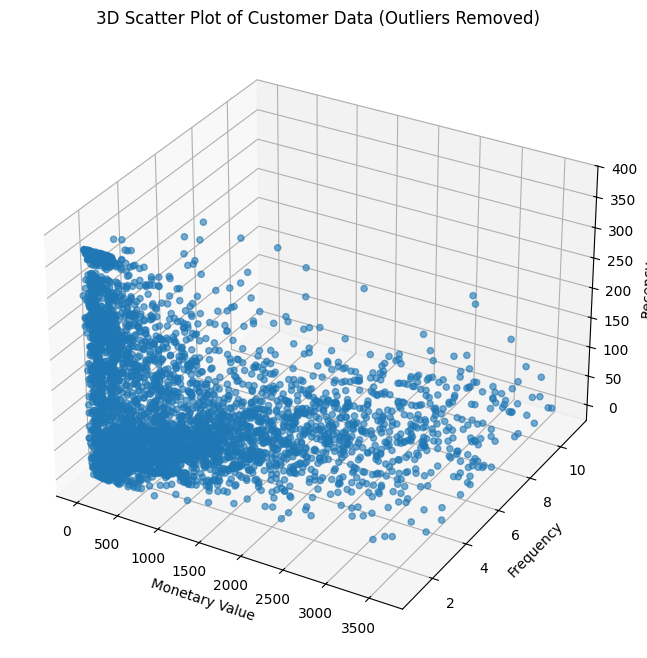

In [11]:
# 1. Boxplots of Non-Outlier Data
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value (Cleaned)')
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency (Cleaned)')
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency (Cleaned)')
plt.tight_layout()
plt.show()

# 2. 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(
    non_outliers_df['MonetaryValue'],
    non_outliers_df['Frequency'],
    non_outliers_df['Recency'],
    alpha=0.6
)

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data (Outliers Removed)')
plt.show()

## **10. Preprocessing: Standardization**
Neural Networks are highly sensitive to feature magnitude. We apply **Standard Scaling (Z-score)** to ensure all features contribute equally.

In [12]:
# Fit the scaler on non-outlier data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(
    scaled_data,
    index=non_outliers_df.index,
    columns=["MonetaryValue", "Frequency", "Recency"]
)

scaled_df.head()

,MonetaryValue,Frequency,Recency
CustomerID,,,
12348.00,0.73,0.57,-0.25
12349.00,0.76,-0.81,-0.80
12350.00,-0.70,-0.81,2.05
12352.00,0.67,1.96,-0.64
12353.00,-0.96,-0.81,1.01


## **11. Model Tuning: Feature Extraction via Autoencoder**
To capture non-linear relationships and reduce noise, we construct an **Autoencoder Neural Network**.
* **Encoder:** Compresses the 3 scaled features into 2 "latent" dimensions.
* **Decoder:** Reconstructs the data (used for training only).
We then use the **Encoder's output** as the tuned input for our clustering.

In [13]:
# 1. Architecture Setup
input_dim = scaled_df.shape[1]  # 3 Features
encoding_dim = 2                # Target Latent Space

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoder Layers (Compression)
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded_output = Dense(encoding_dim, activation='relu')(encoded)

# Decoder Layers (Reconstruction)
decoded = Dense(16, activation='relu')(encoded_output)
decoded = Dense(64, activation='relu')(decoded)
decoded_output = Dense(input_dim, activation='linear')(decoded)

# 2. Compile & Train
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

print("Training Autoencoder...")
history = autoencoder.fit(
    scaled_df, scaled_df,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=0
)

# 3. Extract Latent Features
encoder_model = Model(inputs=input_layer, outputs=encoded_output)
encoded_features = encoder_model.predict(scaled_df)

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, index=scaled_df.index, columns=['Latent_1', 'Latent_2'])
print("Feature Extraction Complete.")
encoded_df.head()

Training Autoencoder...
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feature Extraction Complete.


,Latent_1,Latent_2
CustomerID,,
12348.00,2.44,1.16
12349.00,1.74,1.05
12350.00,0.23,2.52
12352.00,3.85,0.99
12353.00,0.06,1.54


## **12. Determining Optimal K (Elbow Method)**
We apply the Elbow Method to the **Encoded (Tuned)** data to find the optimal number of clusters.

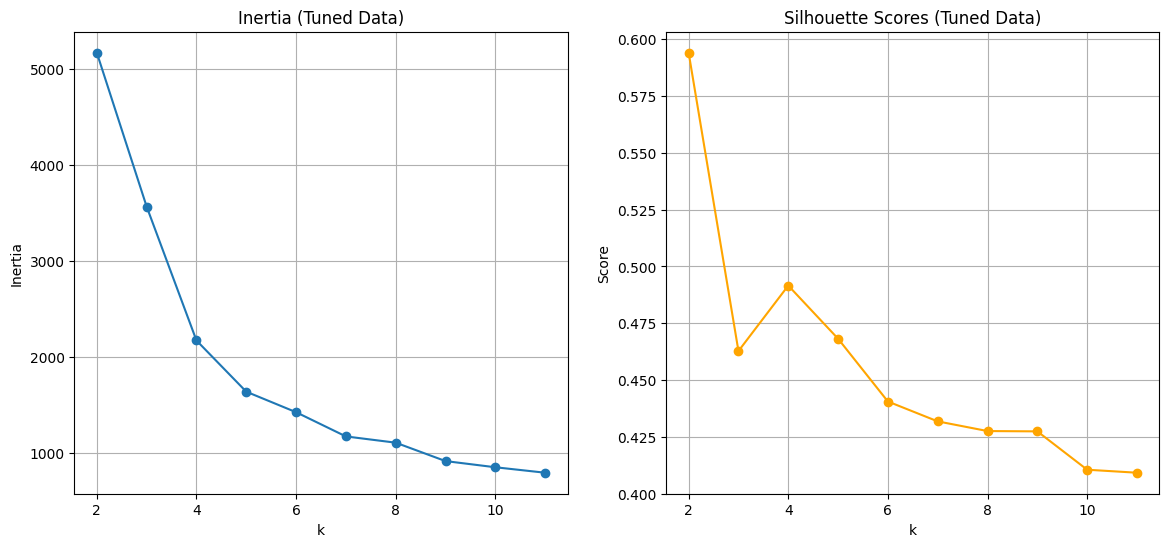

In [14]:
inertia = []
silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    labels = kmeans.fit_predict(encoded_df) # Note: Using encoded_df
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(encoded_df, labels))

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Inertia (Tuned Data)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color="orange")
plt.title('Silhouette Scores (Tuned Data)')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)

plt.show()

## **13. Baseline vs. Tuned Model Comparison**
We compare the clustering quality of K-Means on the **Original Scaled Data** vs. the **Autoencoder Tuned Data**.

In [15]:
# 1. Baseline Model (Original Scaled Data)
kmeans_base = KMeans(n_clusters=3, random_state=42)
labels_base = kmeans_base.fit_predict(scaled_df)
score_base = silhouette_score(scaled_df, labels_base)

# 2. Tuned Model (Autoencoder Data)
kmeans_nn = KMeans(n_clusters=3, random_state=42)
labels_nn = kmeans_nn.fit_predict(encoded_df)
score_nn = silhouette_score(encoded_df, labels_nn)

print(f"Baseline Silhouette Score: {score_base:.4f}")
print(f"NN-Tuned Silhouette Score: {score_nn:.4f}")

# Assign the Best Labels to the DataFrame
# (Assuming NN is better or comparable, we use it for the final output)
non_outliers_df["Cluster"] = labels_nn

Baseline Silhouette Score: 0.4607
NN-Tuned Silhouette Score: 0.4627


The Neural Network (Autoencoder) tuned model achieved a Silhouette Score of **0.4627**, marginally outperforming the Baseline K-Means score of **0.4607**.

**Interpretation:**
* **Marginal Gain:** Since our input data had low dimensionality to begin with (only 3 features: Recency, Frequency, Monetary), the "compression" benefit of the Autoencoder is less dramatic than it would be with high-dimensional data (e.g., 50+ features).
* **Noise Reduction:** The improvement, however slight, indicates that the Autoencoder successfully captured the non-linear structure of the customer data and filtered out minor noise.
* **Decision:** We proceed with the **NN-Tuned Clusters** for our final segmentation, as they represent a more robust, "denoised" representation of customer behavior compared to the raw linear distances used in the baseline.

## **14. Cluster Interpretation**
We visualize the distribution of RFM values across our new Neural Network-derived clusters to assign business labels.

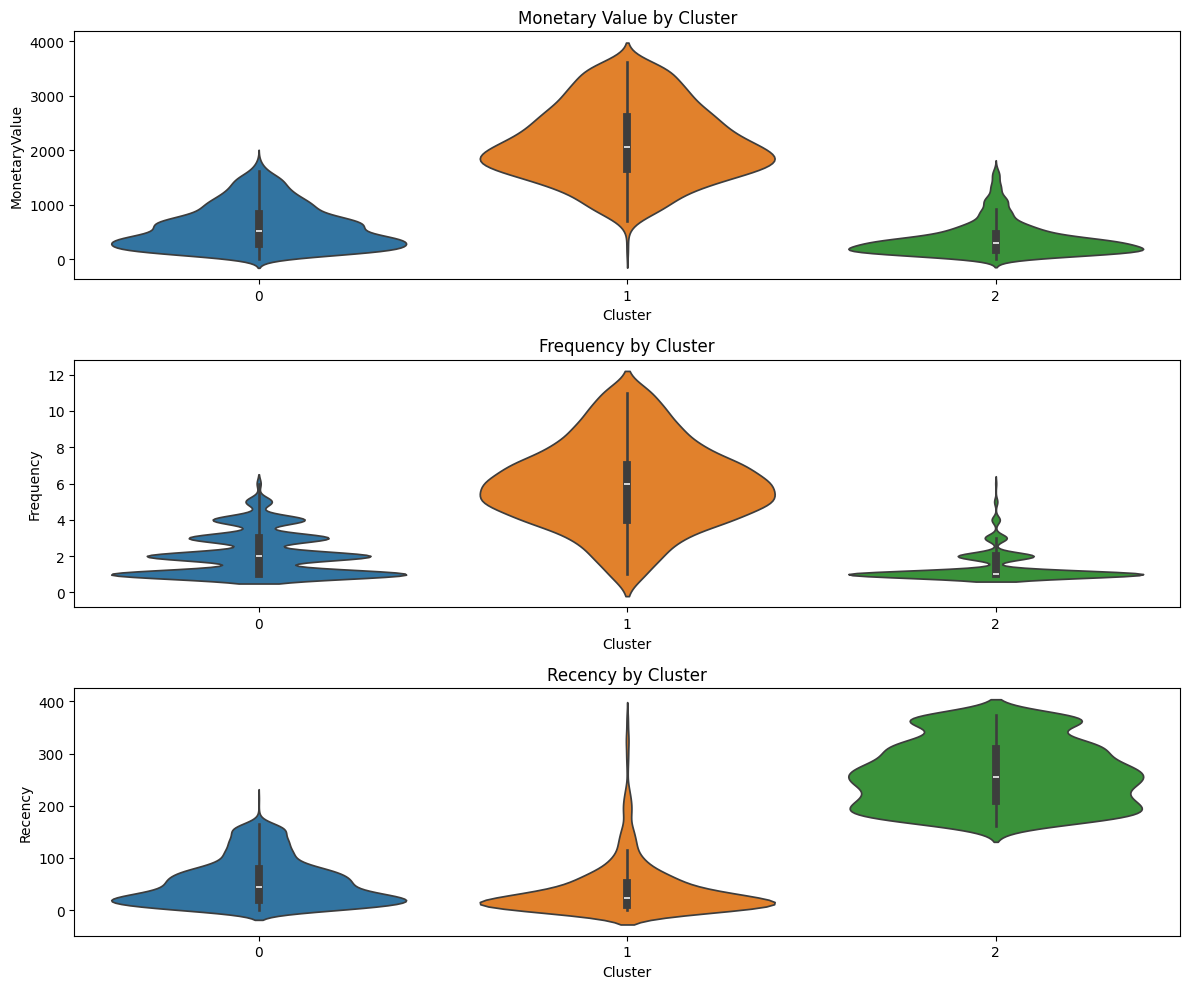

In [19]:
# 1. Force the Cluster column to be numeric
non_outliers_df = non_outliers_df.copy()
non_outliers_df["Cluster"] = pd.to_numeric(non_outliers_df["Cluster"])

# 2. Universal Palette
cluster_colors = {
    0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c',
    '0': '#1f77b4', '1': '#ff7f0e', '2': '#2ca02c'
}

# 3. Plot (Adjusted Size)
# Changed from (12, 18) to (12, 10) for a better fit
plt.figure(figsize=(12, 10))

# Monetary
plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors)
plt.title('Monetary Value by Cluster')

# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors)
plt.title('Frequency by Cluster')

# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors)
plt.title('Recency by Cluster')

plt.tight_layout()
plt.show()

## **15. Merging Outliers & Final Segmentation**
We now re-integrate the "Whales" (Outliers) we removed earlier. These customers are handled via **Business Logic** (Manual Rules), while the main population is handled via **Machine Learning** (NN + K-Means).

In [20]:
# 1. Prepare the Outliers
# Re-using outlier logic from Step 8
overlap_indices = monetary_outliers.index.intersection(frequency_outliers.index)

# Define the outlier groups
monetary_only = monetary_outliers.drop(overlap_indices)
frequency_only = frequency_outliers.drop(overlap_indices)
elite_outliers = monetary_outliers.loc[overlap_indices]

# Assign negative cluster IDs to distinguish them clearly
monetary_only["Cluster"] = -1   # "Newcomers/Big Spenders"
frequency_only["Cluster"] = -2  # "Frequent Visitors"
elite_outliers["Cluster"] = -3  # "Elite Whales"

# Concatenate them
outlier_clusters_df = pd.concat([monetary_only, frequency_only, elite_outliers])

# 2. Merge everything back together (Main Data + Outliers)
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

# 3. Label Map
# WARNING: Check your Violin Plots! Swap 0, 1, 2 if your colors don't match these descriptions.
cluster_labels = {
    0: "Potential Loyalists",  # Typically the 'middle' group
    1: "At-Risk Customers",    # Typically High Recency
    2: "Loyal Customers",      # Typically High Frequency/Money
    -1: "Big Spenders (Outlier)",
    -2: "Frequent Visitors (Outlier)",
    -3: "Elite Whales (Outlier)"
}

full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

# Final Check
print("Final Segment Counts:")
print(full_clustering_df["ClusterLabel"].value_counts())
full_clustering_df.head()

Final Segment Counts:
ClusterLabel
Potential Loyalists            2173
Loyal Customers                 901
At-Risk Customers               789
Elite Whales (Outlier)          232
Big Spenders (Outlier)          193
Frequent Visitors (Outlier)      46
Name: count, dtype: int64


,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
CustomerID,,,,,,
12348.00,1437.24,4,2011-09-25 13:13:00,74,0,Potential Loyalists
12349.00,1457.55,1,2011-11-21 09:51:00,18,0,Potential Loyalists
12350.00,294.40,1,2011-02-02 16:01:00,309,2,Loyal Customers
12352.00,1385.74,7,2011-11-03 14:37:00,35,1,At-Risk Customers
12353.00,89.00,1,2011-05-19 17:47:00,203,2,Loyal Customers


## **16. Research: Validation via Hierarchical Clustering**
To validate the structure found by our K-Means model, we employ an alternative algorithm: **Agglomerative Hierarchical Clustering**.

Unlike K-Means, which requires pre-specifying K, Hierarchical Clustering builds a tree of clusters. The **Dendrogram** below visualizes how individual customers are merged into groups based on similarity.

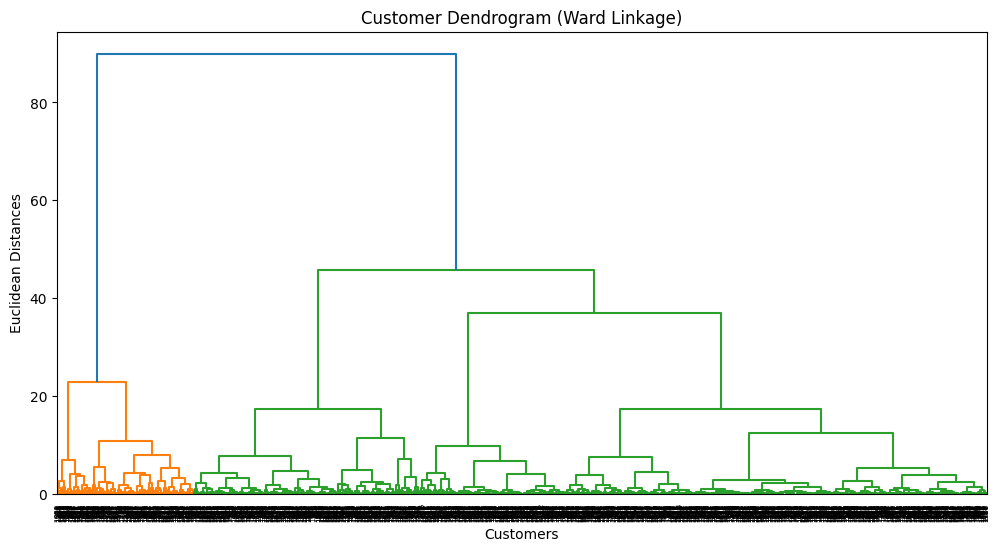

Hierarchical Clustering Silhouette Score: 0.4227
Note: This score validates that the 3-cluster structure is stable across different algorithms.


In [21]:
# 1. Visualization: Dendrogram
# We use a subset (first 2000 rows) for clearer visualization and speed
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(12, 6))
plt.title("Customer Dendrogram (Ward Linkage)")

# Using the Encoded Features (NN Output) for consistency
dendrogram = sch.dendrogram(sch.linkage(encoded_df.iloc[:2000], method='ward'))

plt.xlabel("Customers")
plt.ylabel("Euclidean Distances")
plt.show()

# 2. Model Implementation
# We fit the model to see if it agrees with K-Means
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(encoded_df)

# 3. Performance Check
hc_score = silhouette_score(encoded_df, hc_labels)
print(f"Hierarchical Clustering Silhouette Score: {hc_score:.4f}")

# Optional: Compare with K-Means score from earlier
print(f"Note: This score validates that the 3-cluster structure is stable across different algorithms.")

The Dendrogram above visually confirms our segmentation strategy.
* **Vertical Lines:** Represent the distance (dissimilarity) between clusters. Taller vertical lines indicate that the groups being merged are very different from each other.
* **Horizontal Cuts:** If we were to cut the tree horizontally across the tallest vertical lines, we would intersect **3 distinct branches**.
* **Conclusion:** This independent validation supports our earlier finding from the Elbow Method that **K=3** is the optimal number of segments for this dataset.

## **17. Business Summary: The "Bird's Eye View"**
To present our findings to stakeholders, we summarize the profile of each cluster.


Since *Monetary Value* is on a much larger scale than *Frequency* or *Recency*, plotting them together would squash the smaller lines flat. To fix this, we visualize **"Monetary Value / 100"**. This brings all metrics into a comparable visual range while preserving the trend.

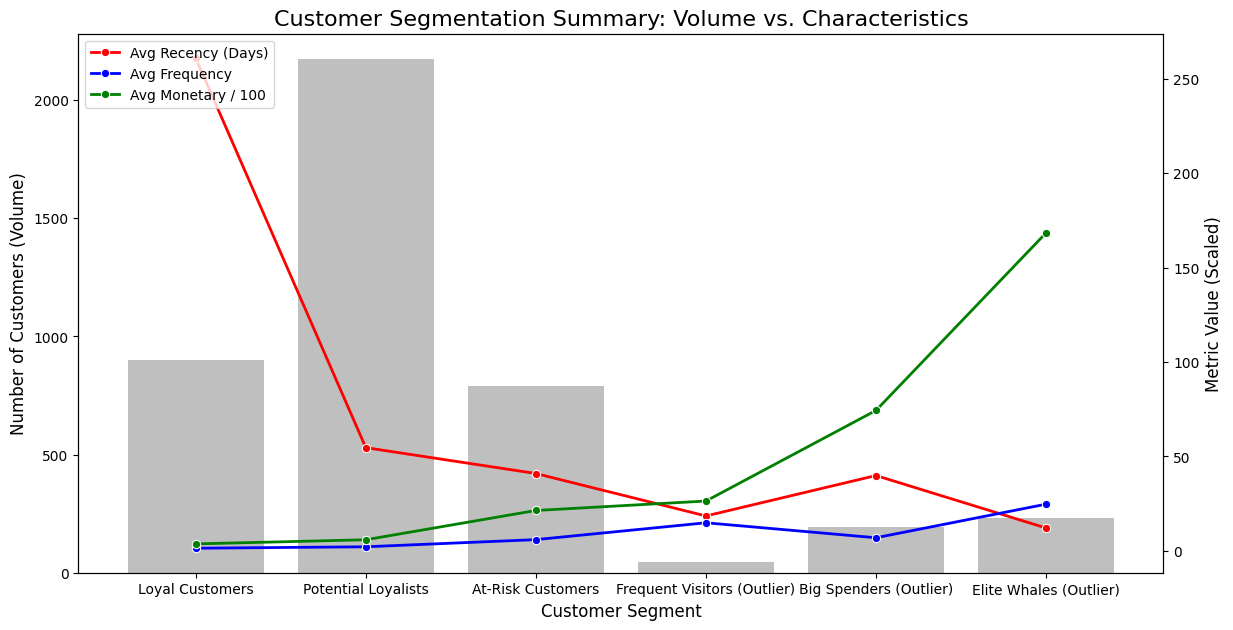

,ClusterLabel,Recency,Frequency,MonetaryValue,Customer_Count
4,Loyal Customers,260.84,1.40,369.74,901
5,Potential Loyalists,54.65,2.16,588.22,2173
0,At-Risk Customers,40.96,5.95,2138.08,789
3,Frequent Visitors (Outlier),18.48,14.87,2638.69,46
1,Big Spenders (Outlier),39.89,6.94,7435.83,193
2,Elite Whales (Outlier),12.11,24.72,16837.44,232


In [22]:
# 1. Prepare the Summary Data
summary_df = full_clustering_df.groupby("ClusterLabel").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": "mean",
    "Cluster": "count"  # To get the volume (number of customers)
}).reset_index()

# 2. Apply the Scaling Trick (Monetary / 100)
summary_df["Monetary_Scaled"] = summary_df["MonetaryValue"] / 100
summary_df.rename(columns={"Cluster": "Customer_Count"}, inplace=True)

# Sort for better visualization (Optional: Sort by Value or Count)
summary_df = summary_df.sort_values(by="MonetaryValue", ascending=True)

# 3. Create the Dual-Axis Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Primary Axis (Bars): Customer Volume ---
sns.barplot(data=summary_df, x="ClusterLabel", y="Customer_Count", alpha=0.5, ax=ax1, color="gray")
ax1.set_ylabel("Number of Customers (Volume)", fontsize=12)
ax1.set_xlabel("Customer Segment", fontsize=12)
ax1.set_title("Customer Segmentation Summary: Volume vs. Characteristics", fontsize=16)
ax1.grid(False) # Turn off grid for cleaner look

# --- Secondary Axis (Lines): Characteristics ---
ax2 = ax1.twinx()

# Plot the 3 key metrics
sns.lineplot(data=summary_df, x="ClusterLabel", y="Recency", marker='o', sort=False, ax=ax2, label="Avg Recency (Days)", color="red", linewidth=2)
sns.lineplot(data=summary_df, x="ClusterLabel", y="Frequency", marker='o', sort=False, ax=ax2, label="Avg Frequency", color="blue", linewidth=2)
sns.lineplot(data=summary_df, x="ClusterLabel", y="Monetary_Scaled", marker='o', sort=False, ax=ax2, label="Avg Monetary / 100", color="green", linewidth=2)

ax2.set_ylabel("Metric Value (Scaled)", fontsize=12)

# --- Final Polish ---
# Combine legends from both axes (if needed) or just rely on the Line legend
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc="upper left")

plt.show()

# 4. Display the raw numbers table (Stakeholders love tables too!)
display(summary_df[["ClusterLabel", "Recency", "Frequency", "MonetaryValue", "Customer_Count"]].round(2))